# Summary:

This project focuses on building a Convolutional Neural Network (CNN) for the classification of plant seedlings into 12 distinct classes using a dataset of 4,750 images. The project progresses through several stages, starting with data preprocessing, and ending with the evaluation of a VGG16 transfer learning model.

## Key Steps:

### Data Preprocessing:

Images were resized from 128x128 to 64x64 to save computational resources.
Gaussian blur was applied to reduce noise.
Dataset was split into training (80%), validation (10%), and testing (10%) sets.
Labels were one-hot encoded, and images were normalized by dividing pixel values by 255.

### Model Architectures:

Base CNN Model: A sequential CNN model was built with two convolutional blocks, max pooling, flattening, and dense layers. The model achieved 94% accuracy on the training, validation, and test sets.
Padded and Batch Normalized Model: Padding and batch normalization layers were added to improve performance. However, this model did not outperform the base model, achieving 93% test accuracy.
CNN Model with Data Augmentation: Techniques like rotation, height/width shift, and flipping were applied to augment the dataset. This improved the model’s generalization and accuracy, achieving 95% on the test set.
CNN with Pretrained VGG16 Model: Transfer learning using the VGG16 architecture with frozen convolutional layers provided the best performance, with a 95% test accuracy. This model demonstrated the highest potential for classifying seedlings accurately.
Evaluation:

Confusion Matrix: The confusion matrices were plotted for all models to visualize misclassifications. The VGG16 model showed significant improvements in correctly predicting most classes.
Comparison of Models: A summary table was created comparing the models based on their training, validation, and test accuracies.
Conclusion:
The VGG16 pretrained model performed the best, achieving 95% accuracy on the test set. Data augmentation and transfer learning significantly improved the model’s ability to generalize well to unseen data. Further improvements could be explored by fine-tuning the pretrained layers or experimenting with more sophisticated augmentation techniques.

# **Importing Necessary Libraries**

In [1]:
import os

#Importing data manipulation and visualisation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
from google.colab.patches import cv2_imshow
import seaborn as sns


# Importing Tensorflow modules
import tensorflow as tf
#Importing image generator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Importing model modules and architechture libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the image and label files of the dataset

seedling_images = np.load('/content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Plant_Seedling/seedling_images.npy')

seedling_labels = pd.read_csv('/content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Plant_Seedling/seedling_labels.csv')

# **Data Overview**

In [3]:
#Checking the shape of the image file
seedling_images.shape

(4750, 128, 128, 3)

- It can be seen from the above that the image file consists of 4,750 colored images with sizes of 128 X 128 pixels

In [4]:
#Checking the shape of the label files
seedling_labels.shape

(4750, 1)

- The labels file can be seen to contain 4,750 labels, which corresponds to the number of images in the images file

In [5]:
#Checking 5 random rows in the labels file
seedling_labels.sample(5)

,Label
111,Small-flowered Cranesbill
2761,Scentless Mayweed
3340,Sugar beet
2526,Cleavers
3194,Scentless Mayweed


In [6]:
#Checking the unique labels
np.unique(seedling_labels)

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

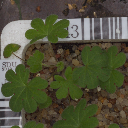

In [7]:
#Using openCV to show some random images
cv2_imshow(seedling_images[3])

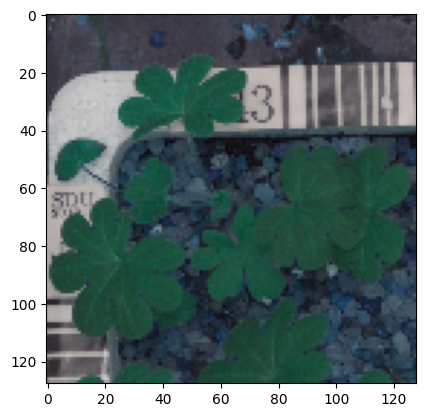

In [8]:
#Using matplotlib to show some images
plt.imshow(seedling_images[3])

- Due to the fact that openCV displays images in BGR, there is a need to convert the images into RGB format for easy interpretation

In [9]:
#Converting the images from BGR ro RGB
for image in range(len(seedling_images)):
  seedling_images[image] = cv2.cvtColor(seedling_images[image], cv2.COLOR_BGR2RGB)

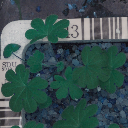

In [10]:
#Rechecking the image
cv2_imshow(seedling_images[3])

# **Explorative Data Analysis**

**There is a need to carry out some further data exploration to help gain further insight into the data**

In [11]:
#Checking the unique number plant seedlings in the dataset

seedling_labels['Label'].nunique()

12

- This confirms that there are 12 different plant seedlings in the dataset

In [12]:
#Checking the number of each plant seedling in the dataset

seedling_labels['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

- The class with the highest number of images is the Loose Silky-bent seedling with 654 images, while the least images in a class is found in Commoin wheat and Maize with 221 images

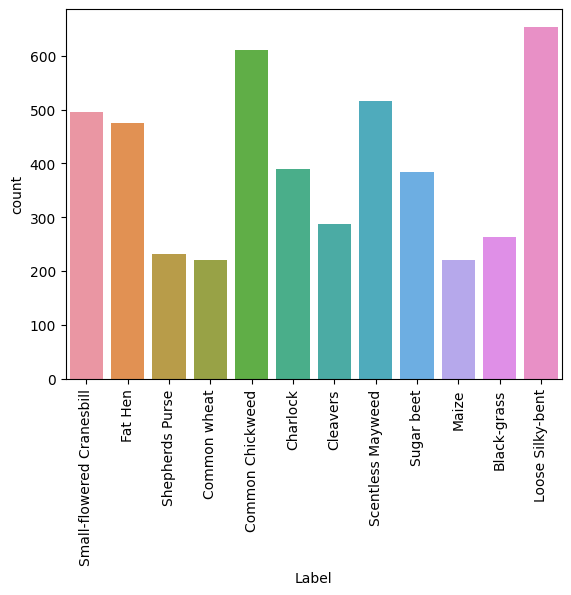

In [13]:
#Visualizing the classes in the dataset to help inspect for data imbalance
sns.countplot(x = 'Label', data = seedling_labels, )
plt.xticks(rotation = 90);

- **The value counts and visualization carried out above indicates that the classes of the data set are not balnanced, and this might affect the performance of the model. Data imbalance treatment would therefore come in handy in hyperparameter tunning to achieve optimum performance**

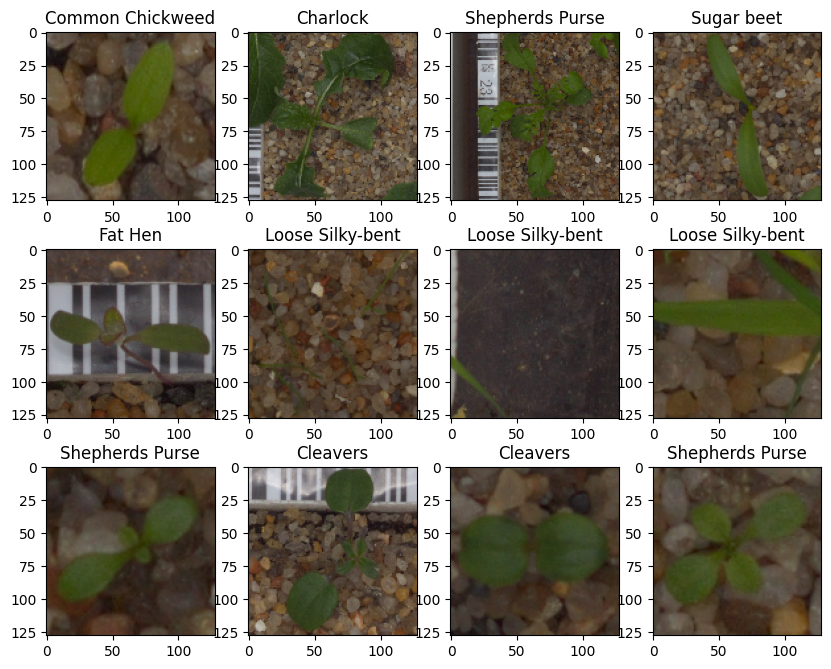

In [14]:
#Visualizing a random sample of 10 images and their their labels

def plot_images(seedling_images, seedling_labels):
  num_class = 12
  categories = np.unique(seedling_labels)
  keys = dict(seedling_labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize = (10, 8))
  for i in range(cols):
    for j in range(rows):
      random_index = np.random.randint(0, len(seedling_labels))
      ax = fig.add_subplot(rows, cols, i * rows + j + 1)
      ax.imshow(seedling_images[random_index, :])
      ax.set_title(keys[random_index])
  plt.show()

plot_images(seedling_images, seedling_labels)

# **Data Preprocessing**

## **Resizing the images**

  It might be cimputationally expensive to train the  model using the default image size of 128 x 128. To save computational resources, the images would be resized to 64 x 64

In [15]:
resized_images = []
height = 64
width = 64
dimensions = (width, height)
for image in range(len(seedling_images)):
  resized_images.append(cv2.resize(seedling_images[image], dimensions, interpolation = cv2.INTER_LINEAR))

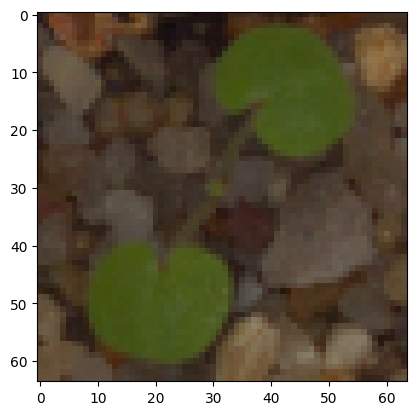

In [16]:
#Taking a look at the resized images

plt.imshow(resized_images[5]);

## **Application of Gaussian blur**

- This serves the purpose of reducing noise and smoothing up the image

In [17]:
gb_images = []
for image in range(len(seedling_images)):
  gb_images.append(cv2.GaussianBlur(seedling_images[image], ksize = (3, 3), sigmaX = 0))

In [18]:
#gb_images = []
#for image in seedling_images:
  #blurred_images = cv2.GaussianBlur(image, (3, 3), 0)
  #gb_images.append(blurred_images)

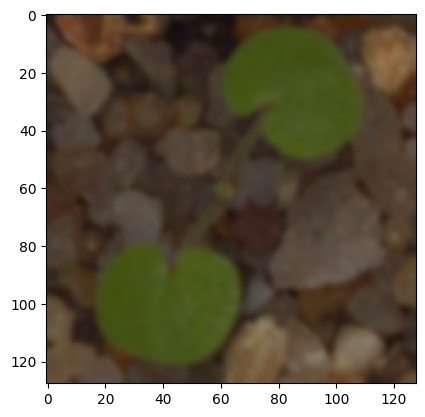

In [19]:
#Taking a look a the Gaussian Blurred image
plt.imshow(gb_images[5]);

- It can be observed that the image on which the Gaussian blur has been applied appears better and smoother that ther raw resized image

## **Splitting the dataset**

- The dataset would be split into the training, validation and testing splits using train_test_split.
- Due to the size of the dataset, only 10% each would be allocated to testing and validation, leaving 80% for the training of the model

In [20]:
#Splitting the images into the training, validation and testing splits
x_temp, x_test, y_temp, y_test = train_test_split(np.array(seedling_images), seedling_labels, test_size = 0.1, random_state = 42, stratify = seedling_labels)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size = 0.1, random_state = 42, stratify = y_temp)

In [21]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3847, 128, 128, 3) (3847, 1)
(428, 128, 128, 3) (428, 1)
(475, 128, 128, 3) (475, 1)


## One Hot Encoding the labels

In [22]:
#Converting the seedling names to one hot vectors using labelBinarizer

from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

## **Data Normalization**

- By normalizing the images, the images would be divided by 255, which is the maximum pixel value images can have, therefore puting the images all on a scale of values between 0 and 1

In [23]:
#Normalizing the images

x_train_normalized = x_train.astype('float32')/255.0
x_val_normalized = x_val.astype('float32')/255.0
x_test_normalized = x_test.astype('float32')/255.0

## **Model Building; Convoluted Neural Network(CNN)**

In [24]:
#Clearing sessions to remove any previously accumulated weights
from tensorflow.keras import backend
backend.clear_session()

In [25]:
#Fixing the random state for number generators to ensure reproducibility

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [26]:
#Initializing a sequential model

model = Sequential()

#Building the first convolutional block consisting of a convolutional layer having 128 filters, a max pooling layer
model.add(Conv2D(128, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

#Building the second convolutional block consisting of a convolutional layer having 64 filters, a max pooling layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(2, 2))

#Flattening the output fro the convokutional layers to make it ready for creating dense connections

model.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and a dropout of 0.3
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))

#Adding the output layer with 12 neurons and an activation function of softmax
model.add(Dense(12, activation = 'softmax'))

#Specifying the optimizer
opt = Adam()

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 100)               5

In [27]:
#Importing EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
#Defining early stopping and model checkpoint
model_filename = '/content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt = ModelCheckpoint(model_filename, verbose = 2, save_best_only = True)

### **Fitting the model on the training data**

In [29]:
history = model.fit(x_train_normalized, y_train_encoded,
                    validation_data = (x_val_normalized, y_val_encoded),
                    batch_size = 32, epochs = 50, verbose = 2, callbacks = [es, chkpt])

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.31843, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings.hdf5
121/121 - 12s - loss: 2.4264 - accuracy: 0.9165 - precision: 0.2500 - recall: 0.0010 - auc: 0.6084 - val_loss: 2.3184 - val_accuracy: 0.9163 - val_precision: 0.2500 - val_recall: 0.0023 - val_auc: 0.7009 - 12s/epoch - 99ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.31843 to 1.98840, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings.hdf5
121/121 - 4s - loss: 2.1869 - accuracy: 0.9169 - precision: 0.5765 - recall: 0.0127 - auc: 0.7308 - val_loss: 1.9884 - val_accuracy: 0.9161 - val_precision: 0.4000 - val_recall: 0.0140 - val_auc: 0.7991 - 4s/epoch - 34ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.98840 to 1.65388, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings.hdf5
121/121 - 4s - loss: 1.9448 - accuracy: 0.9183

### **From the model training above, it can be seen that;**
- The model seems to be generalizing well
- The training loss progressively dropped from 2.1973 to 0.8976 at the 13th epoch, while the validation loss stopped improving after the 10th epoch at 1.06967 from an initial 1.7479.
- The training accuracy was 95% on the 13th epoch, while validation accuracy was 94.6%

## **Model Evaluation**

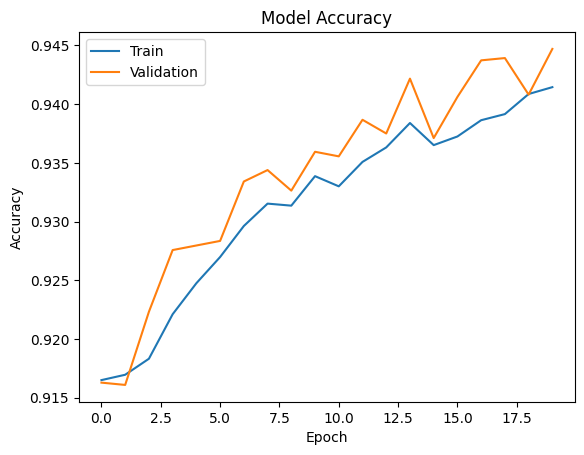

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

- The above plot indeed shoes that the model generalizes well

## **Evaluating the performance of the model on the test data**

In [31]:
accuracy = model.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

15/15 - 0s - loss: 1.2070 - accuracy: 0.9419 - precision: 0.7118 - recall: 0.5095 - auc: 0.9367 - 427ms/epoch - 28ms/step


- The model can be seen to be maintaining its good performance on the test data as well

## **Making prediction using the test data**

In [32]:
y_pred = model.predict(x_test_normalized)

15/15 [==============================] - 0s 9ms/step


## **Plotting comfusion matrix**
- The confusion matrix is a TensorFlow module that can be used to evaluate the performance of classification models
- The confusion matrix however expects inputs to be cartegorical. The y_test_encoded would therefore be required to be converted to categorical values
- Thge argmax() function would be used to retrieve the maximum value for each category, which is used to get the classes of the y_test_encoded and the y_pred(which is in probabilities)

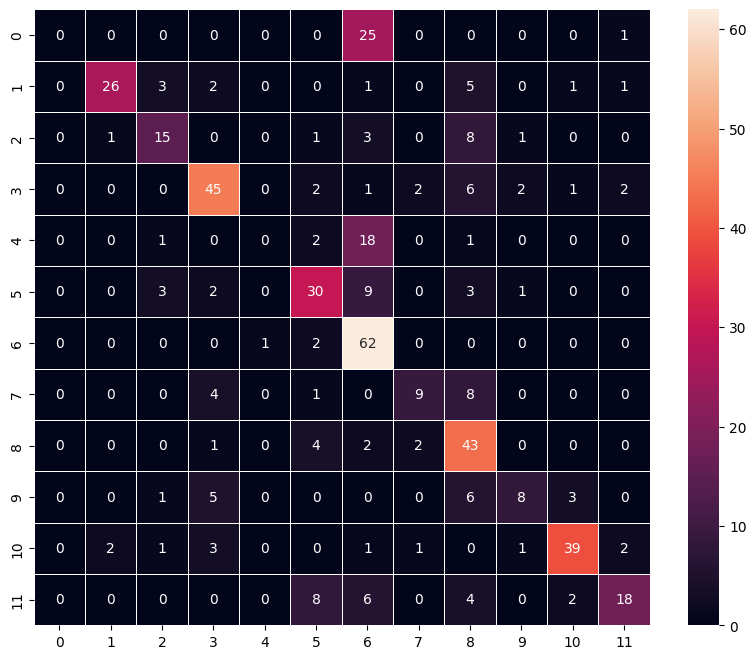

In [33]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- The model can be seen to be doing only fairly well in predicting all the classes. The mistakes it is making is however more pronounced for the '4' and '0' classes.

## **Model Architecture2**

- Padding is being introduced intom the model marchitecture so that the dimension of the input image into the various layers is maintained
- BatchNormalizer is also being introduced to improve the stability of the model

In [39]:
#Clearing sessions to remove any previously accumulated weights
from tensorflow.keras import backend
backend.clear_session()

#Fixing the random state for number generators to ensure reproducibility

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [40]:
#Initializing a second model
model2 = Sequential()

#Building the first convolutional block consisting of a convolutional layer having 128 filters, a max pooling layer, and a batch normalizer
model2.add(Conv2D(128, (3, 3), padding = 'same', input_shape = (128, 128, 3),
                 activation = 'relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#Building the second convolutional block consisting of a convolutional layer having 64 filters, a max pooling layer, and a batch normalizer
model2.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

#Flattening the output fro the convokutional layers to make it ready for creating dense connections

model2.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and a dropout of 0.3
model2.add(Dense(100, activation = 'relu'))
model2.add(Dropout(0.3))

#Adding the output layer with 12 neurons and an activation function of softmax
model2.add(Dense(12, activation = 'softmax'))

#Specifying the optimizer
opt = Adam()

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                        

In [41]:
#Defining early stopping and model checkpoint
model2_filename = '/content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings2.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt2 = ModelCheckpoint(model2_filename, verbose = 1, save_best_only = True)

In [42]:
history2 = model2.fit(x_train_normalized, y_train_encoded,
                    validation_data = (x_val_normalized, y_val_encoded),
                    batch_size = 32, epochs = 50, verbose = 1, callbacks = [es, chkpt2])

Epoch 1/50
120/121 [============================>.] - ETA: 0s - loss: 3.3373 - accuracy: 0.9122 - precision: 0.4161 - recall: 0.1318 - auc: 0.7093
Epoch 1: val_loss improved from inf to 18.87680, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings2.hdf5
121/121 [==============================] - 10s 56ms/step - loss: 3.3363 - accuracy: 0.9122 - precision: 0.4158 - recall: 0.1315 - auc: 0.7090 - val_loss: 18.8768 - val_accuracy: 0.8427 - val_precision: 0.0561 - val_recall: 0.0561 - val_auc: 0.4890
Epoch 2/50
119/121 [============================>.] - ETA: 0s - loss: 1.9950 - accuracy: 0.9229 - precision: 0.6610 - recall: 0.1526 - auc: 0.7944
Epoch 2: val_loss did not improve from 18.87680
121/121 [==============================] - 4s 37ms/step - loss: 1.9916 - accuracy: 0.9229 - precision: 0.6607 - recall: 0.1539 - auc: 0.7954 - val_loss: 22.3491 - val_accuracy: 0.8427 - val_precision: 0.0561 - val_recall: 0.0561 - val_auc: 0.4851
Epoch 3/5

- Model2 seems to be slightly overfitting, as it consistently did better on the training data than on the validation data.
- The training loss ranged from 3.3363 at the first epoch to 1.1901 at the 12th epoch
- The validation loss was 18.8768 at the first epoch, was heighest at 22.3491 at the 2nd epoch and least at 1.3288 at the 9th epoch
- The training accuracy of the model was 94.3%, while the validation accuracy was slightly lower at 93.4%

## **Model2 Evaluation**

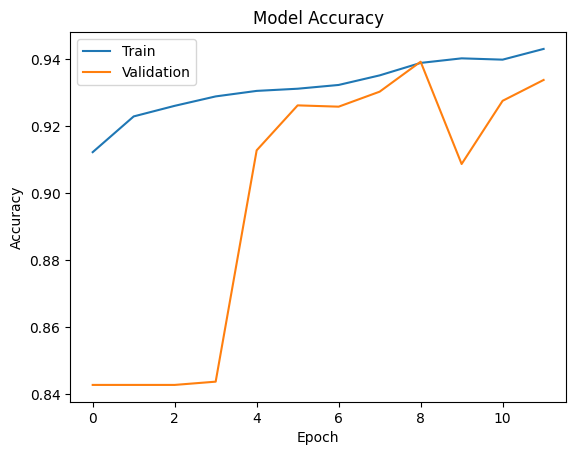

In [43]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

## **Evaluating the performance of model2 on the test data**

In [45]:
accuracy2 = model2.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

15/15 - 0s - loss: 1.7620 - accuracy: 0.9333 - precision: 0.6547 - recall: 0.4232 - auc: 0.8893 - 246ms/epoch - 16ms/step


## **Making prediction using the test data**

In [46]:
y_pred2 = model2.predict(x_test_normalized)

15/15 [==============================] - 0s 12ms/step


## **Plotting confusion matrix**

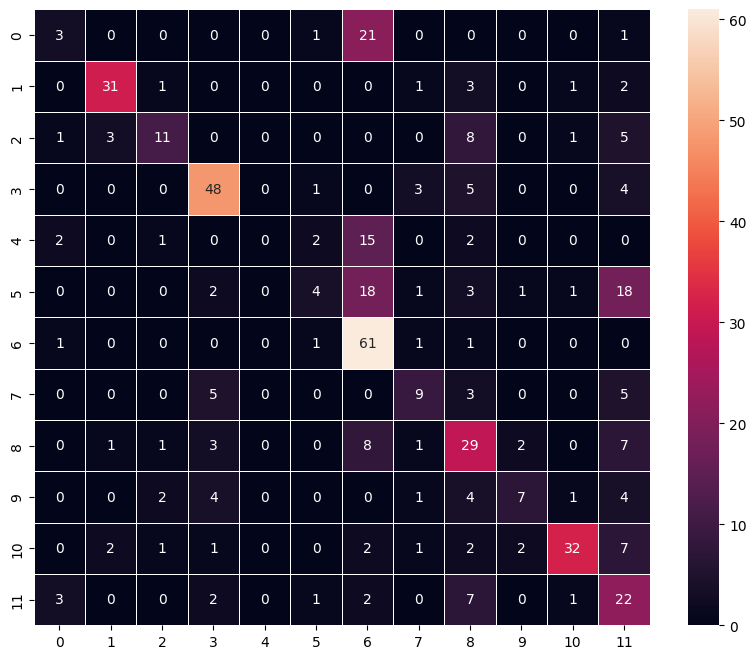

In [47]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred2_arg = np.argmax(y_pred2, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred2_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- The second architecture can be clearly seen to not be making as good predictions as the first architecture

## **Data Augmentation**
To improve the performance of the mode, the size of the data can be increased, using data augmentation. The data can be augmented by applying some changes on the provided image, and storing the changes as a new image. Example of possible changes are listed below;
- Rotation
- Height shift
- Width shift
- Horizontal flip
- Vertical flip
- Shear

**These would be applied to the first architecture in an atempt to improve its performance**

In [55]:
train_datagen = ImageDataGenerator(rotation_range=180, fill_mode='nearest', horizontal_flip=True, vertical_flip=True, shear_range=0.2, zoom_range=0.2)

In [56]:
#Clearing sessions to remove any previously accumulated weights
from tensorflow.keras import backend
backend.clear_session()

In [57]:
#Fixing the random state for number generators to ensure reproducibility

import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [58]:
#Initializing a sequential model

model3 = Sequential()

#Building the first convolutional block consisting of a convolutional layer having 128 filters, a max pooling layer
model3.add(Conv2D(128, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

#Building the second convolutional block consisting of a convolutional layer having 64 filters, a max pooling layer
model3.add(Conv2D(64, (3, 3), activation = 'relu'))
model3.add(MaxPooling2D(2, 2))

#Flattening the output fro the convokutional layers to make it ready for creating dense connections

model3.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and a dropout of 0.3
model3.add(Dense(100, activation = 'relu'))
model3.add(Dropout(0.3))

#Adding the output layer with 12 neurons and an activation function of softmax
model3.add(Dense(12, activation = 'softmax'))

#Specifying the optimizer
opt = Adam()

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
model3.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 100)               5

In [59]:
#Defining early stopping and model checkpoint
model3_filename = '/content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings3.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt3 = ModelCheckpoint(model3_filename, verbose = 2, save_best_only = True)

In [60]:
epochs = 50
batch_size = 62
history3 = model3.fit(train_datagen.flow(x_train_normalized, y_train_encoded,
                                         batch_size = batch_size, seed = 42,
                                         shuffle = False), validation_data =
                                          (x_val_normalized, y_val_encoded),
                      epochs = epochs, verbose = 1, steps_per_epoch =
                      x_train_normalized.shape[0] // batch_size, callbacks =
                       [es, chkpt3])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 2.3084 - accuracy: 0.9158 - precision: 0.2644 - recall: 0.0061 - auc: 0.6870
Epoch 1: val_loss improved from inf to 1.97251, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings3.hdf5
62/62 [==============================] - 17s 250ms/step - loss: 2.3084 - accuracy: 0.9158 - precision: 0.2644 - recall: 0.0061 - auc: 0.6870 - val_loss: 1.9725 - val_accuracy: 0.9132 - val_precision: 0.3043 - val_recall: 0.0327 - val_auc: 0.7998
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.8698 - accuracy: 0.9188 - precision: 0.6086 - recall: 0.0711 - auc: 0.8218
Epoch 2: val_loss improved from 1.97251 to 1.65816, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings3.hdf5
62/62 [==============================] - 15s 239ms/step - loss: 1.8698 - accuracy: 0.9188 - precision: 0.6086 - recall: 0.0711 - auc: 0.8218 - val_loss: 1

- Model3 appears to be generalizing well with validation accuracy mostly higher than training accuracy.
- The validation loss for this model started from 1.9725 from the 1st epoch, and continued to show improvement until the 13th epoch where it had a validation loss of 0.97376.
- The training accuracy obtained at epoch 16 was 93.9%, while the validation accurcy was 94.5%

## **Model3 evaluation**

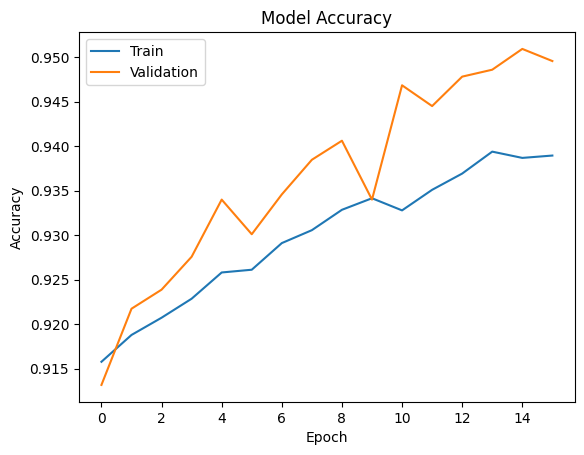

In [61]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

## **Evaluating the performance of model3 on the test data**

In [62]:
accuracy3 = model3.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

15/15 - 0s - loss: 1.0053 - accuracy: 0.9460 - precision: 0.7811 - recall: 0.4884 - auc: 0.9564 - 216ms/epoch - 14ms/step


## **Making prediction using the test data**

In [63]:
y_pred3 = model3.predict(x_test_normalized)

15/15 [==============================] - 0s 11ms/step


## **Plotting confusion matrix**

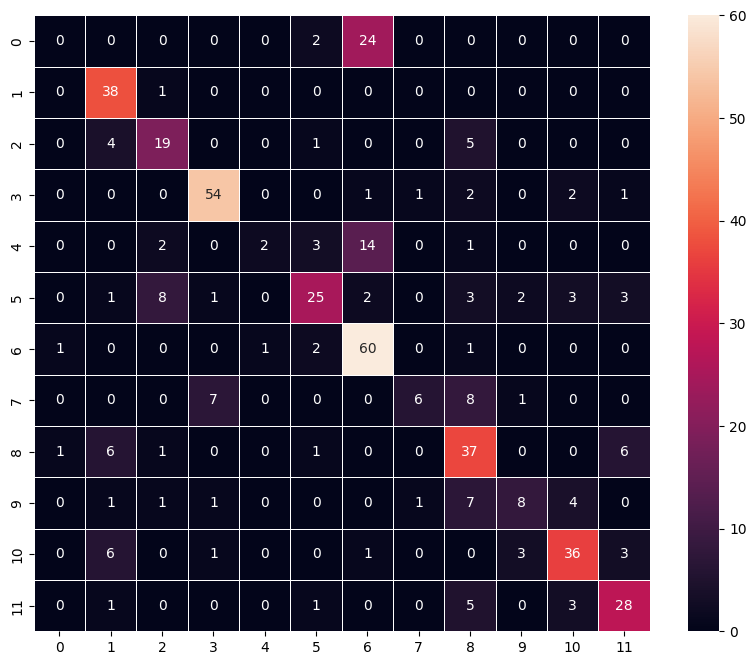

In [64]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred3_arg = np.argmax(y_pred3, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred3_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

- Marked improvements can be observed across the classes. This model however also stills struggle to correctly classify classes '0' and '4'

## **Transfer Leasrning using VGG16**

- For this, a pretrained VGG16 model trained on ImageNet dataset would be used
- The convolutional and pooling layers of the above model would be used directly with the VGG16 architecture while freezing their weights.
- The fully connected layer of the pretrained architecture would however be replaced with that of the problem nodel

In [65]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [66]:
#Freezing the VGG layers so that they don't get trained by the custom model
for layer in vgg_model.layers:
  layer.trainable = False

In [67]:
new_model = Sequential()

#Adding the convolutional part of the VGG16 model above
new_model.add(vgg_model)

#Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

#Adding a fully connected dense layer with 100 neurons and a dropout of 0.3
new_model.add(Dense(100, activation = 'relu'))
new_model.add(Dropout(0.3))

#Adding the output layer with 12 neurons and an activation function of softmax
new_model.add(Dense(12, activation = 'softmax'))

#Specifying the optimizer
opt = Adam()

#Creating an instance for metrics
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

#Compiling the model
new_model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = Metrics)

#Generating the model summary
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               819300    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                1212      
                                                                 
Total params: 15,535,200
Trainable params: 820,512
Non-trainable params: 14,714,688
_________________________________________________________________


In [68]:
#Defining early stopping and model checkpoint
new_model_filename = '/content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings4.hdf5'
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt4 = ModelCheckpoint(model3_filename, verbose = 2, save_best_only = True)

In [69]:
epochs = 50
batch_size = 62
history_vgg16 = new_model.fit(train_datagen.flow(x_train_normalized, y_train_encoded,
                                         batch_size = batch_size, seed = 42,
                                         shuffle = False), validation_data =
                                          (x_val_normalized, y_val_encoded),
                      epochs = epochs, verbose = 1, steps_per_epoch =
                      x_train_normalized.shape[0] // batch_size, callbacks =
                       [es, chkpt4])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 2.3176 - accuracy: 0.9162 - precision: 0.3611 - recall: 0.0069 - auc: 0.6835
Epoch 1: val_loss improved from inf to 2.01341, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings3.hdf5
62/62 [==============================] - 24s 308ms/step - loss: 2.3176 - accuracy: 0.9162 - precision: 0.3611 - recall: 0.0069 - auc: 0.6835 - val_loss: 2.0134 - val_accuracy: 0.9178 - val_precision: 1.0000 - val_recall: 0.0140 - val_auc: 0.7954
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.9625 - accuracy: 0.9183 - precision: 0.6624 - recall: 0.0410 - auc: 0.8008
Epoch 2: val_loss improved from 2.01341 to 1.75277, saving model to /content/drive/MyDrive/Colab_Files/Deep_Learning_AILeadTech/Models/plant_seedlings3.hdf5
62/62 [==============================] - 15s 246ms/step - loss: 1.9625 - accuracy: 0.9183 - precision: 0.6624 - recall: 0.0410 - auc: 0.8008 - val_loss: 1

- The model architecture built on the pretrained VGG16 model is generalizing well, doing better on the validation data than on the training data
- The validation loss progressively decreased, peaking at the 32nd epoch, where it recorded a loss of 0.95433.
- The highest training accuracy was obtained at the 35th epoch where the model stopped to prevent overfitting. The training accuracy stood at 94%, while the validation accuracy stood at 95%.

## **Pretrained model evaluation**

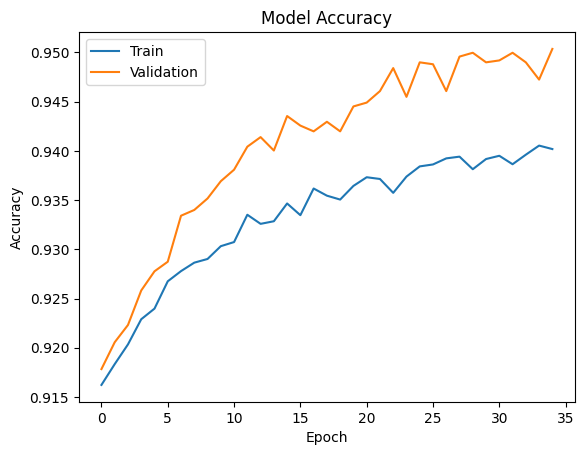

In [70]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

## **Evaluating the performance of the pretrained model on the test data**

In [71]:
accuracy4 = new_model.evaluate(x_test_normalized, y_test_encoded, verbose = 2)

15/15 - 2s - loss: 1.0041 - accuracy: 0.9491 - precision: 0.8201 - recall: 0.4989 - auc: 0.9555 - 2s/epoch - 148ms/step


## **Making prediction using the test data**

In [72]:
y_pred4 = new_model.predict(x_test_normalized)

15/15 [==============================] - 1s 41ms/step


## **Plotting confusion matrix**

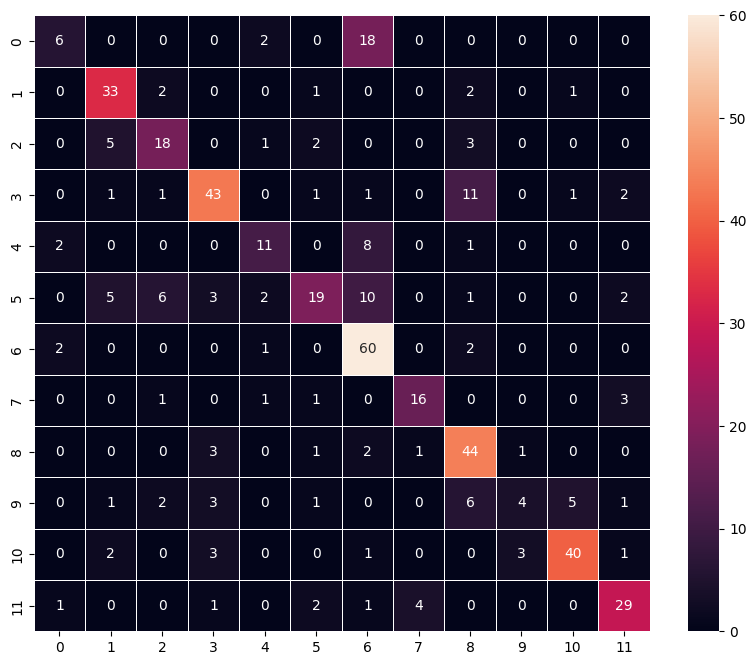

In [73]:
#Retrieving the cartegorical values of the y_test_encoded and the y_pred
y_pred4_arg = np.argmax(y_pred4, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

#Plotting the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred4_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_matrix, annot = True, linewidths = .4, fmt = 'd', square = True, ax = ax)
plt.show()

## **Visualizing the predictions:**

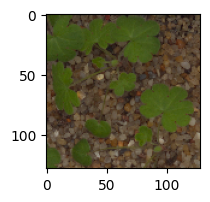

1/1 [==============================] - 1s 539ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


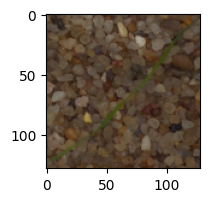

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


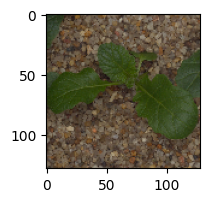

1/1 [==============================] - 0s 23ms/step
Predicted Label ['Charlock']
True Label Charlock


In [74]:
#Visualizing the predicted and the actual labels of the images from the test data
plt.figure(figsize=(2,2))
plt.imshow(x_test[9])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((x_test_normalized[9].reshape(1,128,128,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[9])

plt.figure(figsize=(2,2))
plt.imshow(x_test[24])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((x_test_normalized[24].reshape(1,128,128,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[24])


plt.figure(figsize=(2,2))
plt.imshow(x_test[15])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((x_test_normalized[15].reshape(1,128,128,3)))))
print('True Label', enc.inverse_transform(y_test_encoded)[15])

## **Conclusion**

- Of the four CNN architecture built, the VGG16 pretrained model gave the best performance in correctly classifying most of the seedling classes.
- The VGG16 gave an accuracy of 95% on the test set
- Up the introduction of padding and BatchNormalization, the model didn't seem to have improved
- Data augmentation visibly improved the performancer of the model, giving better performances on the validation and test sets than on the test sets
- Introducing pretrained model further improved the performance of the model

## **Models Summary**

In [76]:
pd.DataFrame({'Models': ['Base CNN Model', 'Padded & Normalized Model', 'CNN Model with Data Augmentation', 'CNN with Pretrained Model(VGG16)'], 'Training Accuracy': ['94%', '94%', '94%', '93%'], 'Validation Accuracy': ['94%', '93%', '94%', '94%'], 'Test Accuracy': ['94%', '93%', '95%', '95%']})

,Models,Training Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,94%,94%,94%
1,Padded & Normalized Model,94%,93%,93%
2,CNN Model with Data Augmentation,94%,94%,95%
3,CNN with Pretrained Model(VGG16),93%,94%,95%
